In [1]:

import importlib
import shiftNMF_frozen
importlib.reload(shiftNMF_frozen)
from shiftNMF_frozen import ShiftNMF
#from shiftNMFDiscTau import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *
from helpers.data import X_ART, X_ART_NOISY, TAU_ART, W_ART, H_ART
from Hardmodel_single_peaks import Single_Model
from Hardmodel import Hard_Model
import scipy
from scipy.signal import find_peaks
import itertools
from helpers.fit_functions import *
from helpers.plot import *
import torch

# Data

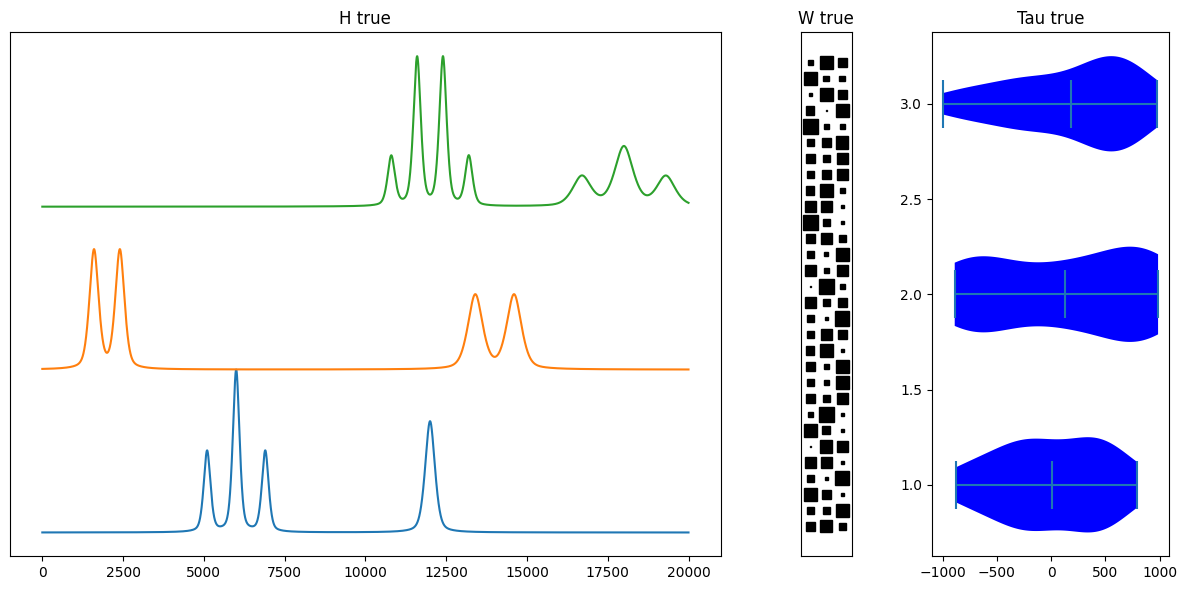

In [2]:
# Create a gridspec object with 2 rows and 3 columns
from helpers.plot import *
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(12, 6))
N, M = X_ART.shape

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, np.arange(H_ART.shape[1]), H_ART.T)
ax1.set_title('H true')

ax2 = plt.subplot(gs[1])
ax2.set_title('W true')
hinton(W_ART.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(TAU_ART, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau true')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

# shiftNMF

epoch: 500, Loss: 0.06744283885073987, Tau: 6166.7922779999655
Found peaks:[ 2095  2901 13907 15088]
sigma: 162.67825467217148 n:9.924021672452917e-06
sigma: 157.9676891264429 n:3.2782031366113807e-07
sigma: 225.5736294307008 n:0.24979657596160623
sigma: 243.57256269125395 n:6.258329207406507e-07
Lorentzian %:s: 0.028830914345891165
tensor([1.3236e-13, 1.3195e-08, 6.1559e-12, 1.0167e-08],
       grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([164.4835, 158.7994, 239.5989, 245.5791], requires_grad=True)
hypothesises:
{(0, 1), (1, 3), (2,), (1, 2), (0, 1, 2), (0, 1, 3), (0, 3), (0, 2, 3), (1, 2, 3), (2, 3), (1,), (0, 2), (0, 1, 2, 3), (0,), (3,)}
tensor(2498.)
torch.Size([1, 20000])
tensor(13907.)
torch.Size([1, 20000])


d:\CodingProjects\Bachelorprojekt\helpers\fit_functions.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


tensor(6301.)
torch.Size([1, 20000])
tensor(6694.6665)
torch.Size([1, 20000])
tensor(14497.5000)
torch.Size([1, 20000])
tensor(2901.)
torch.Size([1, 20000])
tensor(8497.7500)
torch.Size([1, 20000])
tensor(2095.)
torch.Size([1, 20000])
tensor(15088.)
torch.Size([1, 20000])
tensor(2498.)
torch.Size([1, 20000])
tensor(13907.)
torch.Size([1, 20000])
tensor(6301.)
torch.Size([1, 20000])
tensor(6694.6665)
torch.Size([1, 20000])
tensor(14497.5000)
torch.Size([1, 20000])
tensor(2901.)
torch.Size([1, 20000])
tensor(8497.7500)
torch.Size([1, 20000])
tensor(2095.)
torch.Size([1, 20000])
tensor(15088.)
torch.Size([1, 20000])
epoch: 1, Loss: 0.019805174755978282
tensor(2498.)
torch.Size([1, 20000])
tensor(13907.)
torch.Size([1, 20000])
tensor(6301.)
torch.Size([1, 20000])
tensor(6694.6665)
torch.Size([1, 20000])
tensor(14497.5000)
torch.Size([1, 20000])
tensor(2901.)
torch.Size([1, 20000])
tensor(8497.7500)
torch.Size([1, 20000])
tensor(2095.)
torch.Size([1, 20000])
tensor(15088.)
torch.Size([1, 20

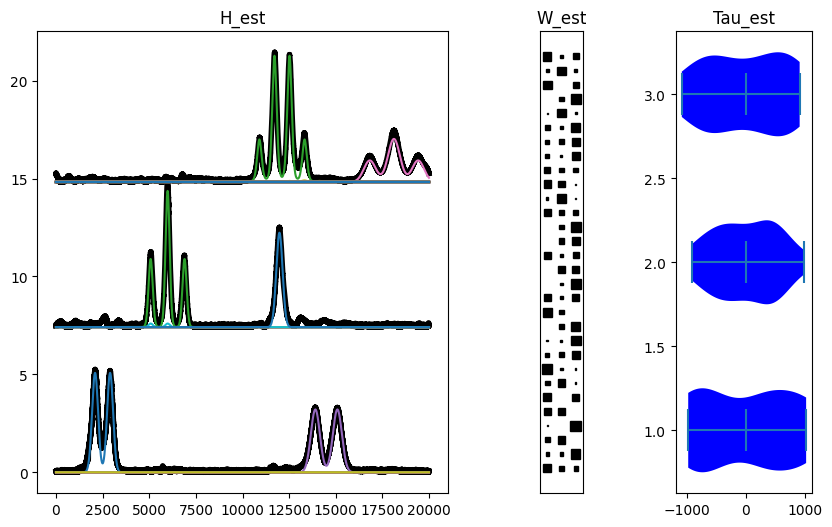

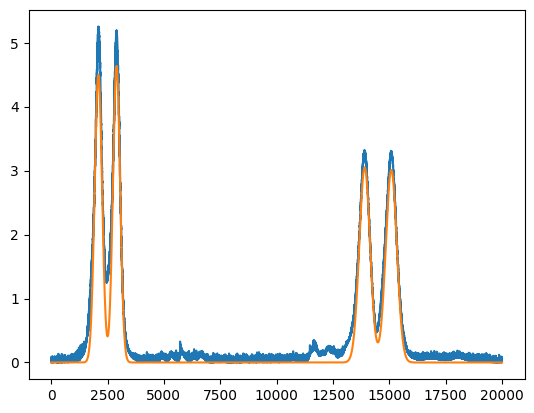

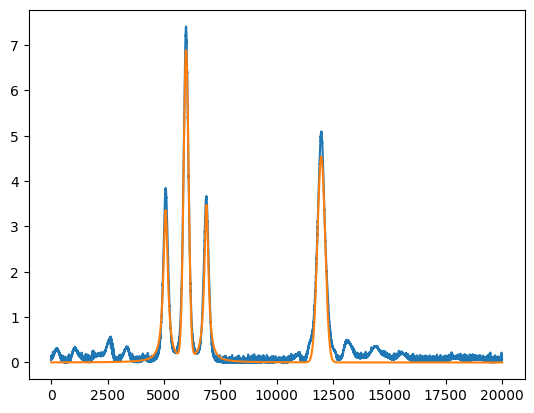

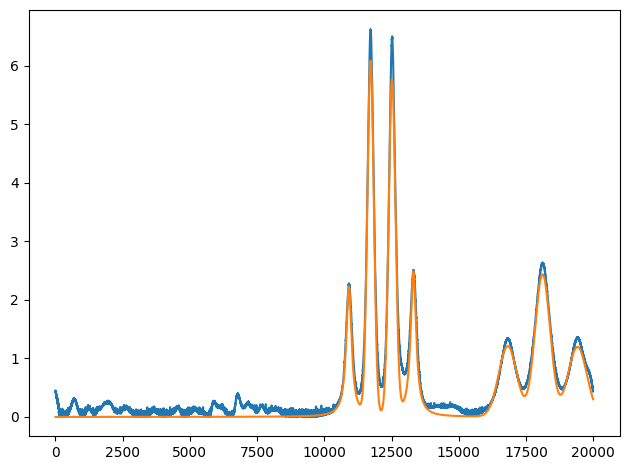

In [3]:

torch.manual_seed(40)

nmf = ShiftNMF(X_ART_NOISY, 3, lr=0.1, alpha=1e-6, patience=30, min_imp=0.001)
W_est, H_est, tau_est = nmf.fit(verbose=1, max_iter=500, tau_iter=0)

fig = plt.figure(figsize=(10, 6))
# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

# Plot H and H_est
ax1 = plt.subplot(gs[0])
# plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')
x = np.arange(H_est.shape[1])

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*3)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# plt.figure(figsize=(15,5))
# plt.plot(H_est.T)
# plt.savefig("shiftcomponents")
# plt.clf()
ymax = 0
for i in range(len(H_est)):
    ymax = max(ymax,(H_est[i]/np.std(H_est[i])).max())
yoffset = ymax
reg_paths = []
lambda_axis = []
C_path = []

for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i])
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)

    W, C, running_loss, path, lambdas = hardmodel.fit(verbose=True, return_loss=True)
    reg_paths.append(path)
    lambda_axis.append(lambdas)
    C_path.append(C)
    means, sigma, j_coup, mult, n = hardmodel.return_values()
    print("means:")
    print(means)
    print("sigmas:")
    print(sigma)
    print("J coupling:")
    print(j_coup)
    print("multiplicity")
    print(mult)
    print("N")
    print(n)

    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    # plt.figure(figsize=(15,5))
    # plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5, color="k")
    ax1.plot(x,H_est[i]/np.std(H_est[i])+yoffset*i, linewidth=4, color="k")
    for j, vec in enumerate(C):
        ax1.plot(x,vec*W[:,j]+yoffset*i)
# Set tight layout
plt.tight_layout()
plt.show()

[ 3.76848809e+01  1.53871142e+01  3.51347911e-01  1.29029104e-01
  1.38364116e-02  1.00859529e-02  8.76727737e-03  3.53921965e-03
  1.30724240e-03  9.62181135e-04  2.89525903e-04 -2.88614703e-04]


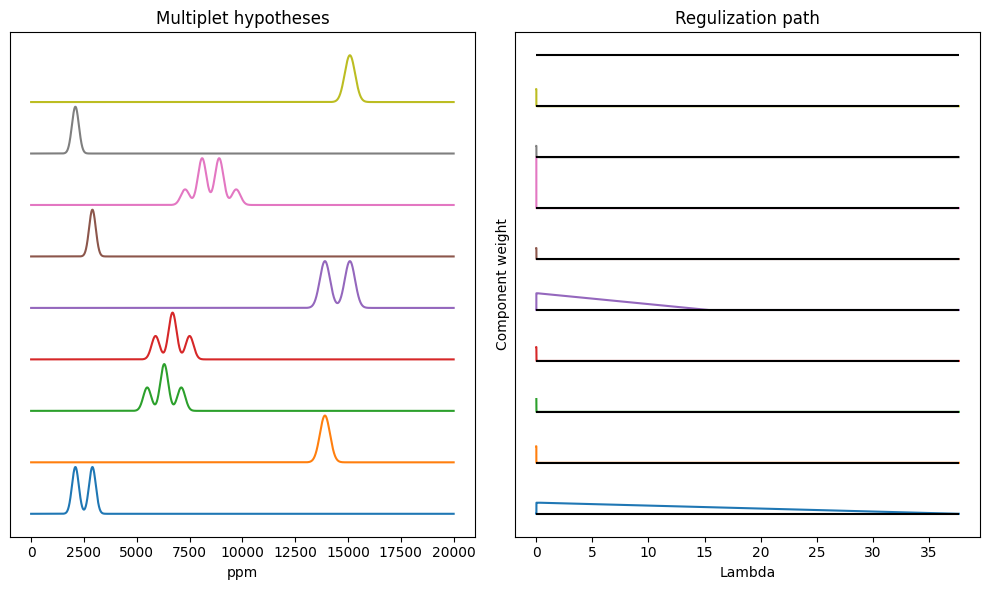

[ 5.65170705e+01  5.46008757e+01  1.79053382e+01  5.31735752e-01
  2.45581764e-01  2.50749455e-02  1.57559588e-02  1.61303527e-03
  1.45061068e-04 -1.51400697e-04]


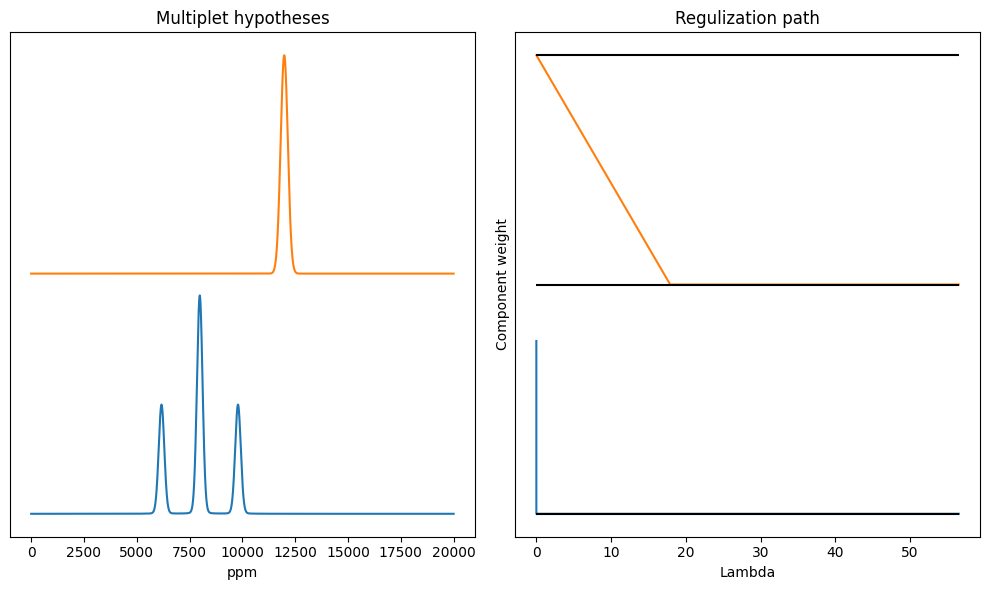

[ 6.35526205e+01  7.27220765e+00  6.95452993e+00  3.08886792e+00
  1.11553789e+00  8.70146639e-01  6.78784937e-01  4.76477194e-01
  4.68225104e-01  4.11627431e-01  2.15078284e-01  1.94793772e-01
  1.87623306e-01  1.26691289e-01  9.73149445e-02  9.11250084e-02
  8.39422299e-02  7.28398293e-02  6.88129416e-02  6.85417429e-02
  6.84730459e-02  5.52136727e-02  4.15141473e-02  3.80982612e-02
  2.27064865e-02  1.93094463e-02  1.77565779e-02  1.66221192e-02
  1.55501493e-02  1.46007647e-02  1.09707924e-02  9.30184089e-03
  7.57299969e-03  5.72122805e-03  5.43059618e-03  5.10028543e-03
  4.52366258e-03  3.61160045e-03  3.27998730e-03  3.12254405e-03
  3.03294638e-03  3.02066865e-03  2.63196848e-03  1.48563704e-03
  8.94406523e-04  8.04278952e-04  7.47324349e-04  7.37946977e-04
 -2.59741033e-04]


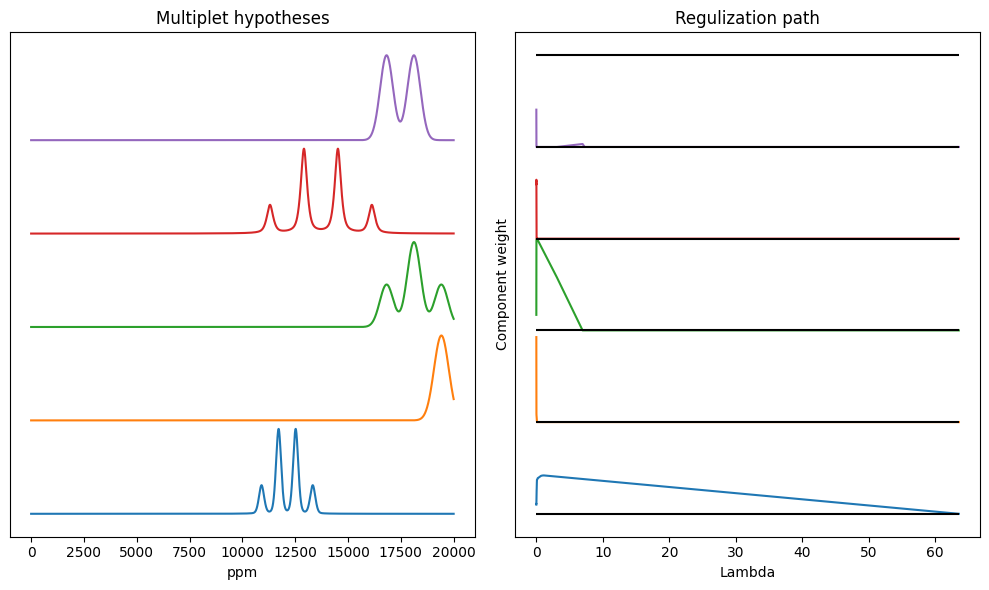

In [4]:

for i in range(len(reg_paths)):
    path = reg_paths[i]
    lambdas = lambda_axis[i]
    print(lambdas[0])
    C = C_path[i]

    fig = plt.figure(figsize=(10, 6))
    # Create a gridspec object with 2 rows and 3 columns
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Plot H and H_est
    ax1 = plt.subplot(gs[0])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax1.set_title('Multiplet hypotheses')

    ax1.set_xlabel("ppm")
   
    x = np.arange(H_est.shape[1])

    ax2 = plt.subplot(gs[1])
    ax2.set_title('Regulization path')
    ax2.set_xlabel("Lambda")
    ax2.set_ylabel("Component weight")

    ax1.tick_params(left = False, labelleft = False)
    ax2.tick_params(left = False, labelleft = False)

    ymax = 1.1
    # for j, vec in enumerate(C):
    #     ymax = max(ymax,(C[j]/max(C[j])).max())

    cutoff = [0, 300, 300]

    yoffset = ymax
    t = 0
    for j, vec in enumerate(C):
        if any(path[0][j] > cutoff[i]):
            ax1.plot(x,vec/max(vec)+yoffset*t)
            t += 1

    
    ymax = path[0].max()
    yoffset = ymax
    t = 0
    for j, vec in enumerate(C):
        if any(path[0][j] > cutoff[i]):
            ax2.plot(lambdas[0],path[0][j]+yoffset*t)
            ax2.hlines(yoffset*t,lambdas[0][-1],lambdas[0][0], color="k")
            t +=1
    ax2.hlines(yoffset*t,lambdas[0][-1],lambdas[0][0], color="k")



    #plt.title("Hardmodelled component regulization path")
    #plt.plot(lambdas[0], reg_paths[i][0].T)
    # plt.savefig("fig"+str(i)+"_path")
    plt.tight_layout()
    plt.show()

# peak finding (single fit)

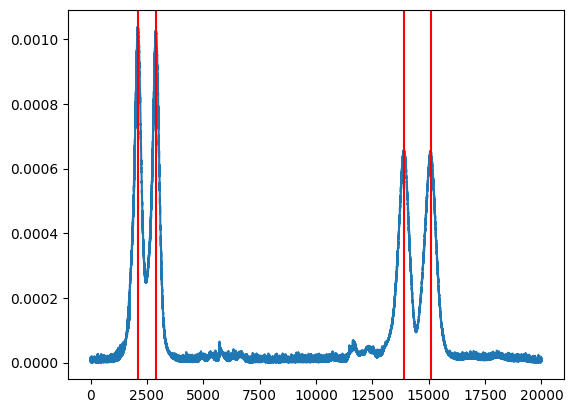

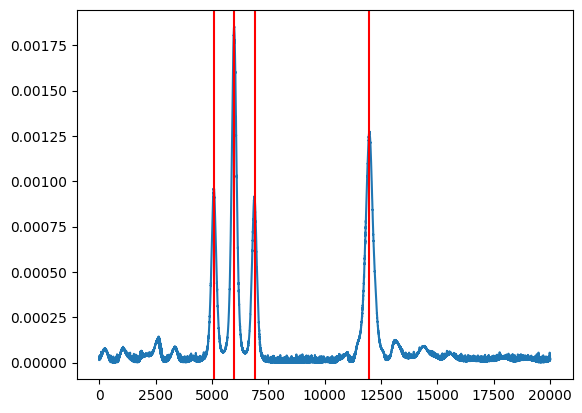

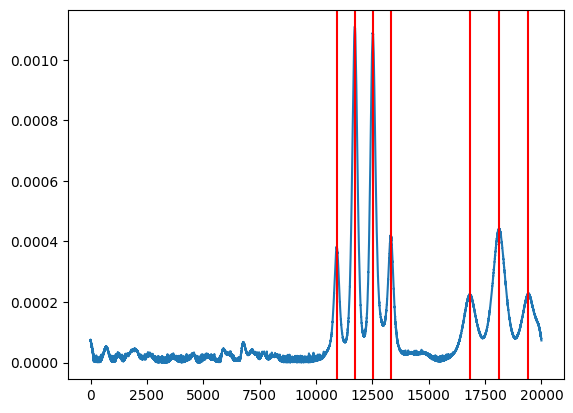

In [5]:

for i in range(len(H_est)):
    plt.plot(H_est[i])
    #peaks = find_peaks_cwt(H_est[i], [100,300])
    peaks = find_peaks(H_est[i], height=max(H_est[i])/10)[0]
    sigmas = scipy.signal.peak_widths(H_est[i], peaks, wlen=1000)[0]/2 #.355*1.5
    select = [sig>100 for sig in sigmas]
    select = [i for i, x in enumerate(select) if x == False]
    sigmas = np.delete(sigmas, select)
    peaks = np.delete(np.array(peaks), select)
    for mean in peaks:
        plt.axvline(mean, color='r')
    plt.show()

# Hardmodel

Found peaks:[ 2095  2901 13907 15088]
sigma: 162.6782571429194 n:9.924028332280397e-06
sigma: 157.98273987114368 n:4.99710560691356e-07
sigma: 225.60692902624422 n:0.24967056814618357
sigma: 243.5767977473962 n:5.66207973291237e-07
Lorentzian %:s: 0.028810020260207618
tensor([1.3190e-13, 9.3324e-09, 6.1536e-12, 1.1097e-08],
       grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([164.4836, 158.8353, 239.5971, 245.6593], requires_grad=True)
hypothesises:
{(0, 1), (1, 3), (2,), (1, 2), (0, 1, 2), (0, 1, 3), (0, 3), (0, 2, 3), (1, 2, 3), (2, 3), (1,), (0, 2), (0, 1, 2, 3), (0,), (3,)}
tensor(2498.)
torch.Size([1, 20000])
tensor(13907.)
torch.Size([1, 20000])
tensor(6301.)
torch.Size([1, 20000])
tensor(6694.6665)
torch.Size([1, 20000])
tensor(14497.5000)
torch.Size([1, 20000])
tensor(2901.)
torch.Size([1, 20000])
tensor(8497.7500)
torch.Size([1, 20000])
tensor(2095.)
torch.Size([1, 20000])
tensor(15088.)
torch.Size([1, 20000])


TypeError: Hard_Model.fit() got an unexpected keyword argument 'alpha'

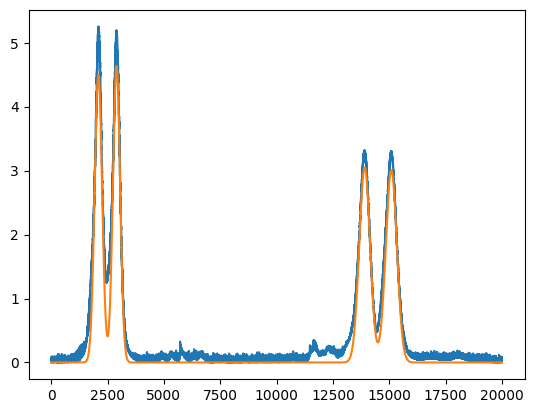

In [7]:
for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i])
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)
    W, C = hardmodel.fit(verbose=True, alpha=0.2)
    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5)

    for i, vec in enumerate(C):
        plt.plot(vec*W[:,i])
    plt.title("C weigthed")
    plt.show()